In [14]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
 
%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython
 
from os.path import join as pjoin
import glob
import numpy as np
from numpy import hstack as stack
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
sns.set_style('darkgrid')
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15,10)
mpl.rcParams['image.cmap'] = 'inferno'


from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error as MSE
from statsmodels.tsa.stattools import acf

from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
# Retail sales of beer, wine and liquor in the U.S.
# Monthly data from January 1992 till November 2017
BeerWine = pd.read_csv('data/BeerWineUS.csv', header=0, index_col=0,
                       squeeze=True)

# Real (inﬂation corrected) interest rate for bank deposits with
# investment durations between one and two years
interestrate = pd.read_csv('data/interestrate.csv', sep=';',
                           index_col=0, header=None).iloc[:,0]
interestrate = interestrate.map(lambda s: float(s.replace(',', '.')))

# Crude oil price per barrel
CrudeOil = pd.read_csv('data/CrudeOil.csv', header=0, index_col=0, squeeze=True)

#### Simple forecasting and forecasting with exponential smoothing with `BeerWineUS.csv`. Begin the forecasting starting with the observation 201. Thus the out-of-sample performance of the below methods will be assessed using the forecasts for the periods 201 to 311.

311: 201 + 110


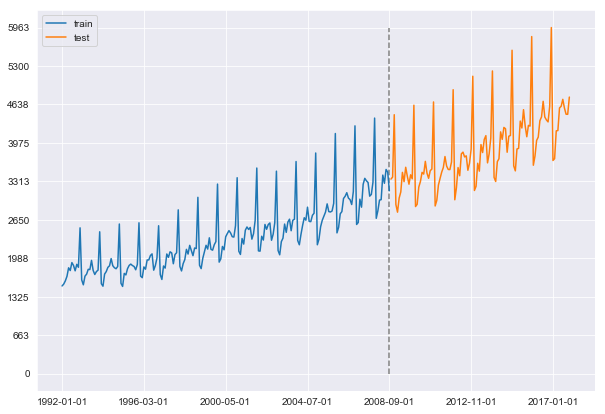

In [3]:
mpl.rcParams['figure.figsize'] = (10,7)
N = len(BeerWine)
n_train = 201
train, test, n_test = split_ts(BeerWine, n_train)

(a) Compute forecasts using simple EWMA, Holt and Holt-Winters forecasts with the smoothing parameters calibrated from the ﬁrst 200 observations.

In [8]:
forecasts = {}

# EWMA
ewma = ExponentialSmoothing(train, trend=None, damped=False, seasonal=None)
forecast_values = ewma.predict(ewma.fit().params,
                               start='1992-01-01', end='2017-11-01')
ewma_result = pd.Series(forecast_values, index=BeerWine.index)
forecasts['EWMA'] = ewma_result.iloc[n_train:]

# Holt
holt = ExponentialSmoothing(train, trend='add', damped=False, seasonal=None)
forecast_values = holt.predict(holt.fit().params,
                               start='1992-01-01', end='2017-11-01')
holt_result = pd.Series(forecast_values, index=BeerWine.index)
forecasts['Holt'] = holt_result.iloc[n_train:]

# Holt-Winters
holtWinters = ExponentialSmoothing(train, trend='add', damped=False,
                                   seasonal='mul', seasonal_periods=12)
forecast_values = holtWinters.predict(holtWinters.fit().params,
                                      start='1992-01-01', end='2017-11-01')
holtWinters_result = pd.Series(forecast_values, index=BeerWine.index)
forecasts['Holt-Winters'] = holtWinters_result.iloc[n_train:]

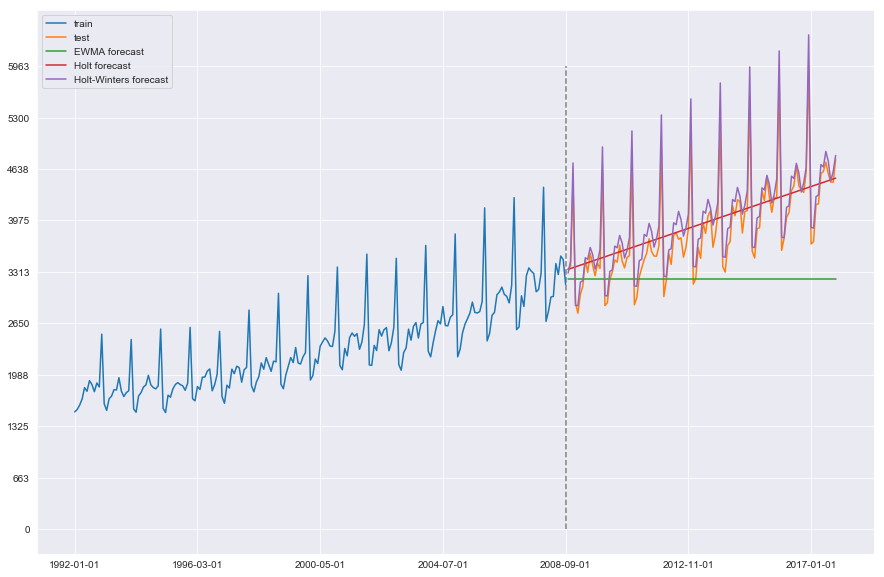

In [9]:
keys = ['EWMA', 'Holt', 'Holt-Winters']

show_series(train, test)

for i, k in enumerate(keys):
    plt.plot(forecasts[k], label='{} forecast'.format(k), color='C{}'.format(i+2))

plt.legend()
plt.show()

(b) Compute the corresponding MSE losses. Check the ACF of the forecast errors.

In [12]:
print('\tEWMA\t\tHolt\t\tHolt-Winters')
print('MSE:\t{:.1f}\t{:.1f}\t{:.1f}'.format(MSE(test, forecasts['EWMA']),
                                            MSE(test, forecasts['Holt']),
                                            MSE(test, forecasts['Holt-Winters'])))

	EWMA		Holt		Holt-Winters
MSE:	791343.8	234909.3	38023.6


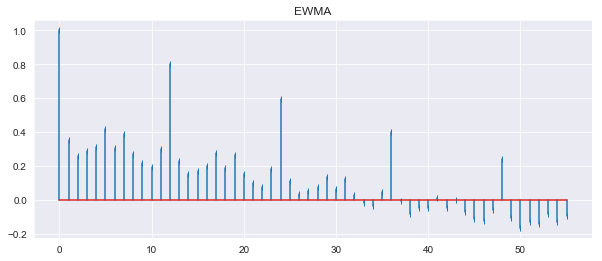

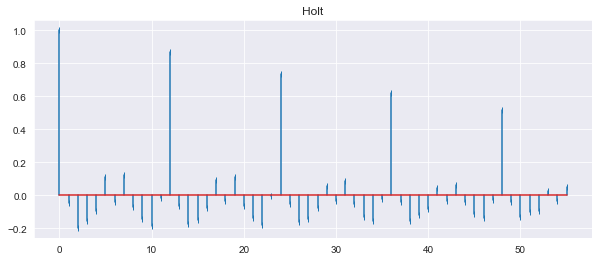

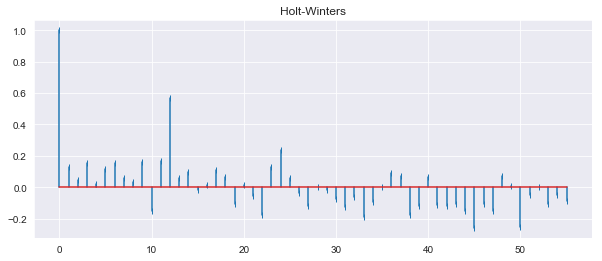

In [16]:
mpl.rcParams['figure.figsize'] = (10,4)

for k in keys:
    ACF(test, forecasts[k], title=k)

(c) Compare the performance of the models using the three tests discussed in the lectures.

In [19]:
from itertools import combinations

print('Comparing the performance with 3 tests')
print('Diff. is [model 1] - [model 2]')
alpha = None
for (k1,k2) in combinations(keys, 2):
    f1, f2 = forecasts[k1], forecasts[k2]
    print('================================\nmodel 1: {}\nmodel 2: {}'.format(k1, k2))
    print('\n1. Sign test')
    EPA_sign(test, f1, f2, k1, k2, alpha)
    print('\n2. Wilcoxon sign test')
    EPA_Wilcoxon(test, f1, f2, alpha)
    print('\n3. Diebold-Mariano test')
    EPA_Diebold_Mariano(test, f1, f2, k1, k2, alpha)
#     print(dm_test(test, f1, f2))

Comparing the performance with 3 tests
Diff. is [model 1] - [model 2]
model 1: EWMA
model 2: Holt

1. Sign test
p-value is 9.33E-07. For all α > 9.33E-07 we can reject H0.
Since the p-value is very small, we see that the Holt model is better than EWMA.

2. Wilcoxon sign test
p-value is 1.95E-08. For all α > 1.95E-08 we can reject H0.
The p-value is very small, so the second model is much better than None.

3. Diebold-Mariano test
p-value is 1.70E-08. For all α > 1.70E-08 we can reject H0.
The p-value is very small, so the Holt model is better than EWMA.
model 1: EWMA
model 2: Holt-Winters

1. Sign test
p-value is 5.55E-16. For all α > 5.55E-16 we can reject H0.
Since the p-value is very small, we see that the Holt-Winters model is better than EWMA.

2. Wilcoxon sign test
p-value is 0.00E+00. For all α > 0.00E+00 we can reject H0.
The p-value is very small, so the second model is much better than None.

3. Diebold-Mariano test
p-value is 4.28E-09. For all α > 4.28E-09 we can reject H0.
